In [1]:
# !pip install numpy==1.21.5  # Needed by imaginaryNLP

### Load source datasets

In [3]:
from datasets import load_dataset, Dataset, DatasetDict, concatenate_datasets
import pandas as pd

daily_dialog = load_dataset("daily_dialog")
prosocial_dialog = load_dataset("allenai/prosocial-dialog")
air_dialogue = load_dataset("air_dialogue")

Found cached dataset daily_dialog (/home/diwank/.cache/huggingface/datasets/daily_dialog/default/1.0.0/1d0a58c7f2a4dab5ed9d01dbde8e55e0058e589ab81fce5c2df929ea810eabcd)


  0%|          | 0/3 [00:00<?, ?it/s]

Found cached dataset json (/home/diwank/.cache/huggingface/datasets/allenai___json/allenai--prosocial-dialog-94297629a652ae73/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


  0%|          | 0/3 [00:00<?, ?it/s]

No config specified, defaulting to: air_dialogue/air_dialogue_data
Found cached dataset air_dialogue (/home/diwank/.cache/huggingface/datasets/air_dialogue/air_dialogue_data/1.1.0/38932dc01f4fbf071a129beb7c4afd0982306ab8bc7c994f050467014df5e4a5)


  0%|          | 0/2 [00:00<?, ?it/s]

### Process prosocial dialog

In [4]:
prosocial_dialog_pd = {}

def collect_responses(grouped_row):
    grouped_row = grouped_row.sort_values("response_id")
    spkr_a = grouped_row["context"].tolist()
    spkr_b = grouped_row["response"].tolist()
    
    zipped = zip(spkr_a, spkr_b)
    utterances = [utterance for pair in zipped for utterance in pair]
    
    return dict(utterances=utterances)
    
for split in prosocial_dialog.keys():
    prosocial_dialog_pd[split] = prosocial_dialog[split].to_pandas()
    prosocial_dialog_pd[split] = prosocial_dialog_pd[split].groupby(["dialogue_id"]).apply(collect_responses)

prosocial_dialog_processed = DatasetDict(**{
    split: Dataset.from_list([dict(dialog=row["utterances"]) for row in data.tolist()])
    for split, data in prosocial_dialog_pd.items()
})

### Process air dialogue

In [9]:
def process_air_dialogue(row):
    # "dialogue" column format:
    # > ["customer: hi", "agent: hello", ...]
    #
    # Get utterances (notice difference between dialog and dialogue columns)
    dialog = [utterance.split(':')[-1].strip() for utterance in row["dialogue"]]
    
    result = dict(dialog=dialog)
    return result

air_dialogue_processed = air_dialogue.map(process_air_dialogue)

# Doesn't have a test split, so let's add it
ad_validation_split = air_dialogue_processed["validation"].train_test_split(0.5)

air_dialogue_processed["validation"] = ad_validation_split["train"]
air_dialogue_processed["test"] = ad_validation_split["test"]

Loading cached processed dataset at /home/diwank/.cache/huggingface/datasets/air_dialogue/air_dialogue_data/1.1.0/38932dc01f4fbf071a129beb7c4afd0982306ab8bc7c994f050467014df5e4a5/cache-835f96dbb8e90454.arrow
Loading cached processed dataset at /home/diwank/.cache/huggingface/datasets/air_dialogue/air_dialogue_data/1.1.0/38932dc01f4fbf071a129beb7c4afd0982306ab8bc7c994f050467014df5e4a5/cache-30ad3254375c68fb.arrow


### Rebalance datasets

In [17]:
import math

datasets = dict(
    air_dialogue=air_dialogue_processed,
    prosocial_dialog=prosocial_dialog_processed,
    daily_dialog=daily_dialog,
)

datasets_len = {
    key: len(ds["train"])
    for key, ds in datasets.items()
}

largest_dataset_len = max(datasets_len.values())

multipliers = {
    key: math.ceil(largest_dataset_len / length)
    for key, length in datasets_len.items()
}

def get_multiplied_datasets_by_split(split):
    concatted = []

    for key, ds in datasets.items():
        concatted.extend([ds[split]] * multipliers[key])

    return concatted

### Concat datasets

In [21]:
dataset = {}

for split in prosocial_dialog.keys():
    dataset[split] = concatenate_datasets(get_multiplied_datasets_by_split(split))

dataset = DatasetDict(**dataset)

# Remove all columns except "dialog"
dataset = dataset.remove_columns(list(set(dataset["train"].column_names) - {"dialog"})).shuffle()

### Make sure to "look at the dataset"

In [23]:
{
    key: ds["train"][:2]["dialog"]
    for key, ds in datasets.items()
}

{'air_dialogue': [['Hello.',
   'Hello. How may I help you?',
   'Can you help me to change my recent reservation because my trip dates are got postponed?',
   'I will help you with that please share your name to proceed further?',
   'Edward hall here.',
   'Please wait for a while.',
   'Sure, take your own time.',
   'There is no active reservation found under your name to amend it.',
   "That's ok, thank you for checking.",
   'Thank you for choosing us.'],
  ['HI.',
   'Hello. How may I be of your address?',
   'I want to book a flight ticket to Las Vegas with price under 1000. Can you please help me with it?',
   'Sure, can I know your connection limit?',
   'I need a single connection.',
   'Please let me know your boarding and landing points.',
   'Airport codes are HOU-LAS.',
   'Kindly share your planned travelling dates to proceed further.',
   'Travel dates are 04/03 and 04/05.',
   'Please wait a while.',
   'Ok.',
   'We found a Frontier airline matching your essential de

### Visualize

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# if using a Jupyter notebook, includue:
%matplotlib inline

In [30]:
all_with_length = dataset.map(lambda row: dict(length=len(" ".join(row["dialog"]).split(" "))))
min(all_with_length["train"]["length"]), max(all_with_length["train"]["length"])

Loading cached processed dataset at /home/diwank/.cache/huggingface/datasets/air_dialogue/air_dialogue_data/1.1.0/38932dc01f4fbf071a129beb7c4afd0982306ab8bc7c994f050467014df5e4a5/cache-4fee1ffe9f7ac4b5.arrow
Loading cached processed dataset at /home/diwank/.cache/huggingface/datasets/air_dialogue/air_dialogue_data/1.1.0/38932dc01f4fbf071a129beb7c4afd0982306ab8bc7c994f050467014df5e4a5/cache-a79debe39d0feb34.arrow
Loading cached processed dataset at /home/diwank/.cache/huggingface/datasets/air_dialogue/air_dialogue_data/1.1.0/38932dc01f4fbf071a129beb7c4afd0982306ab8bc7c994f050467014df5e4a5/cache-496c3bdb7edf5fbd.arrow


(8, 885)

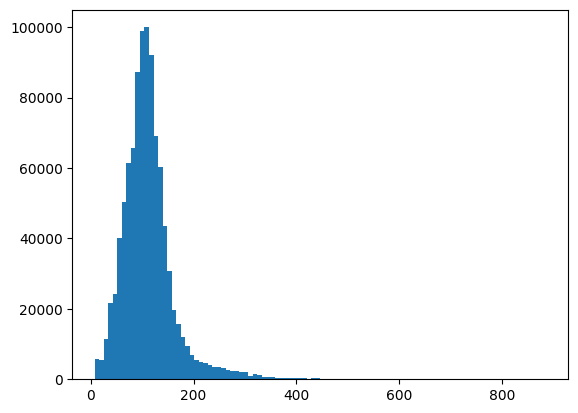

In [31]:
dialog_lengths = np.array(all_with_length["train"]["length"])

plt.hist(dialog_lengths, 100)
plt.show()

### Push to hub

In [33]:
dataset.push_to_hub("diwank/imaginary-nlp-dataset")

Pushing split train to the Hub.
Resuming upload of the dataset shards.


Pushing dataset shards to the dataset hub:   0%|          | 0/2 [00:00<?, ?it/s]

Pushing split validation to the Hub.


Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/107 [00:00<?, ?ba/s]

Deleting unused files from dataset repository:   0%|          | 0/1 [00:00<?, ?it/s]

Pushing split test to the Hub.


Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/119 [00:00<?, ?ba/s]

Deleting unused files from dataset repository:   0%|          | 0/1 [00:00<?, ?it/s]